# Cuckoo genetics: final notes

    author: Gekkonid Consulting
    date: 2021-11-04

In [1]:
library(tidyverse)
library(SNPRelate)
library(pcaMethods)
library(adegenet)
library(hierfstat)
knitr::opts_chunk$set(
  fig.width = 8, fig.height = 6, message=F
)
if (!dir.exists('out/final')) dir.create('out/final')

── Attaching packages ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.0      ✔ purrr   1.0.0 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.5.0 
✔ readr   2.1.3      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


ERROR: Error in library(SNPRelate): there is no package called ‘SNPRelate’


## Background

This study examines the population structure among Little Bronze Cuckoos using hyRAD, a combination of hybrid capture and RADseq. The samples were a mix of museum samples, mostly egg shells, nests, feathers or other ancient samples, and fresh samples, mostly adults (blood), with a smaller number of preserved chicks or embryos.

We obtained read data for 86 samples. Of these, 73 were hyRAD samples, 4 were RADseq libraries from which hybridisation probes were created, and the remaining nine were negative controls of various forms.

## Variant calling

#### Detection of putative RAD loci

We called variants using the [Acanthophis](https://github.com/kdm9/Acanthophis) pipeline. Briefly, we aligned reads to the Common Cuckoo reference genome (TODO: find and add correct genbank ID) with [BWA-MEM](https://arxiv.org/abs/1303.3997), and marked PCR duplicate reads with [samtools markdup](https://pubmed.ncbi.nlm.nih.gov/33590861). We called variants genome-wide with [samtools mpileup](http://www.ncbi.nlm.nih.gov/pubmed/21903627), and normalised variants around indels with [bcftools norm](https://pubmed.ncbi.nlm.nih.gov/33590861). We then filtered variants: first, we kept only variants nearby putative RAD loci (see below). We filtered remaining variants, keeping only those that met the following criteria: biallelic SNPs, variant quality > 50, total site depth > 10, total site depth < 1000, minor allele frequency > 3%, missing data < 80%. We performed further filtering for some subsequent analyses as detailed below.

We identified putative RAD loci using two complimentary metrics. We used [radsim](https://github.com/kdm9/radhax/) to digitally digest the Cuckoo reference genome and report valid ddRAD loci of length 50-500bp bordered by one EcoRI and MspII restriction site each. We then aligned source ddRAD libraries for four samples (TODO: which) to the cuckoo reference. We then calculated the coverage of each putative RAD locus identified by radsim using the combined four ddRAD libraries (using [mosDepth](https://academic.oup.com/bioinformatics/article/34/5/867/4583630?guestAccessKey=35b55064-4566-4ab3-a769-32916fa1c6e6)). We finally kept putative RAD loci which had at least 5x coverage for at least 50bp. In total, we identified approximately 8000 such putative loci.

## Initial genetic analyses

### Data quality

Our first analyses concern data quality: what proportion of data is missing, both per-SNP and per-sample?

In [2]:
samphist = read_tsv("data/1_filtered/cuckoo_q50_dp10_maf3_mis80_radloci_samphist.tsv")
bcfhist = read_tsv("data/1_filtered/cuckoo_q50_dp10_maf3_mis80_radloci_bcfhist.tsv")
meta = read_csv("../rawdata/cuckoo_metadata_oct2021.csv")

Rows: 82 Columns: 2
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (1): sample
dbl (1): missing_prop

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 6939 Columns: 3
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (1): metric
dbl (2): percent, nsnp

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 103 Columns: 17
── Column specification ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

First, per-snp statistics:

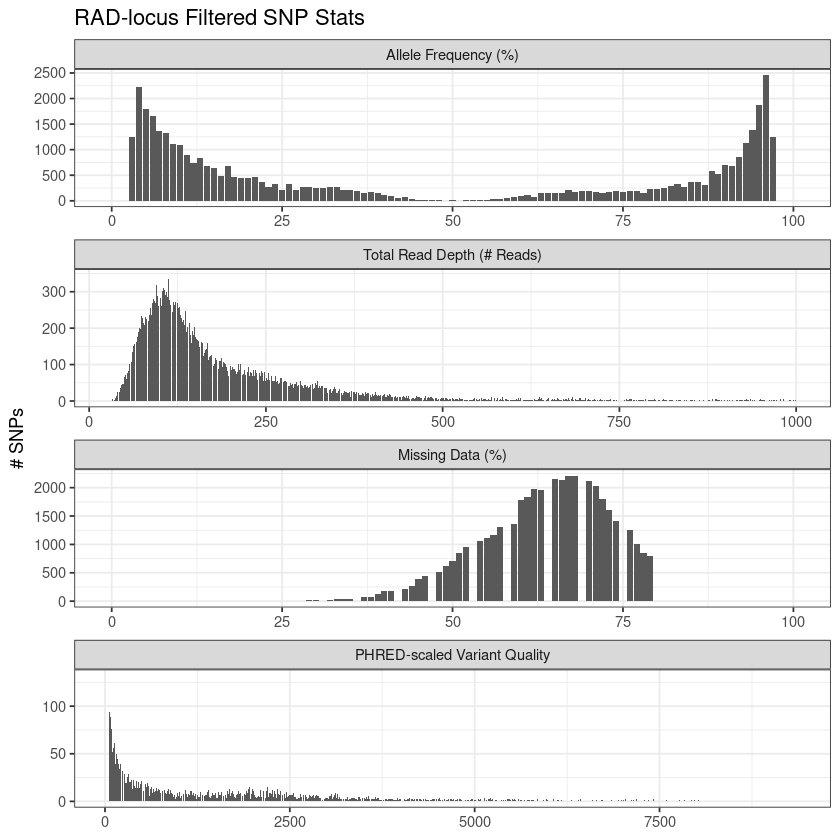

In [28]:
ggplot(bcfhist, aes(x=percent, y=nsnp)) +
    geom_bar(stat="identity") +
    facet_wrap(~metric, ncol=1, scales="free", labeller = as_labeller(
        c("af"="Allele Frequency (%)", "dp"="Total Read Depth (# Reads)",
          "miss"="Missing Data (%)", "qual"="PHRED-scaled Variant Quality")
    )) +
    labs(title="RAD-locus Filtered SNP Stats", y="# SNPs", x=NULL) +
    theme_bw()
ggsave("out/final/radstats.pdf", height=6, width=5)

Overall, there is a significant number of SNPs with a large amount of missing data. The other statistics are as expected, particular the large number of low-MAF alleles including many which are high frequency (almost fixed differences between LBC and European Cuckoo).

Next, the samples:

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 21 rows containing non-finite values (`stat_bin()`).”
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 21 rows containing non-finite values (`stat_bin()`).”


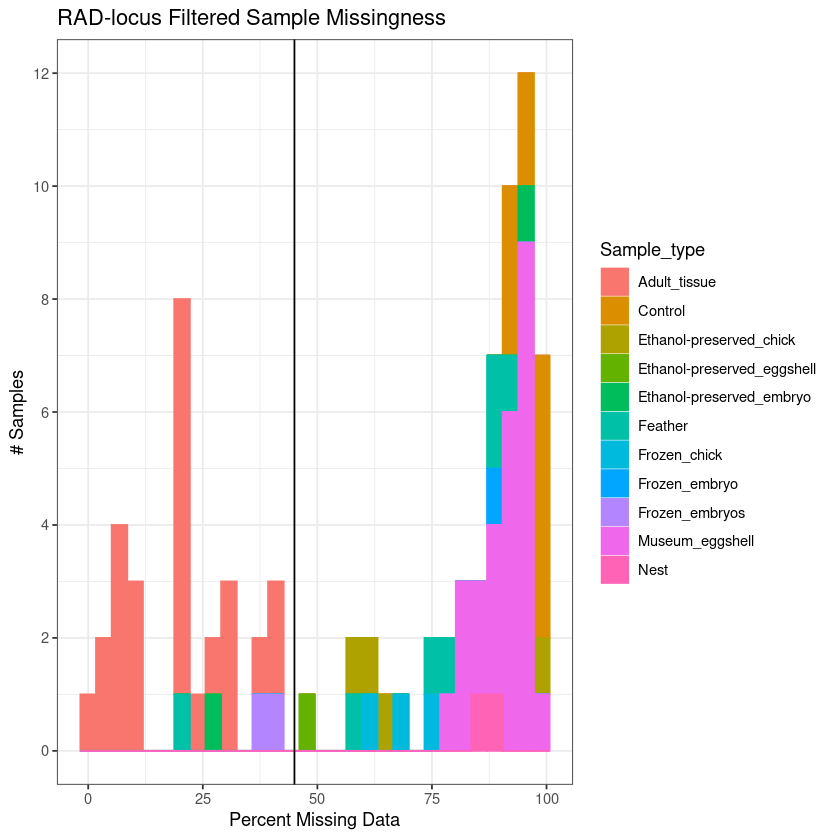

In [33]:
col.plot = meta %>%
    left_join(samphist, by=c("Library_id"="sample"))
ggplot(col.plot, aes(x=missing_prop*100)) +
    geom_histogram(aes(fill=Sample_type, colour=Sample_type)) +
    scale_y_continuous(breaks=seq(0, 12, 2)) +
    geom_vline(xintercept = 45) +
    labs(title="RAD-locus Filtered Sample Missingness",
        y="# Samples", x="Percent Missing Data") +
    theme_bw()
ggsave("out/final/sample-missing.pdf", height=4, width=5)

This is somewhat disheartening: despite our best efforts to find the highest-quality SNPs, the vast majority of museum samples (e.g. Museum_eggshell) have a huge amount of missing data. This will confound any joint analysis, and so at this point we split the dataset in two: fresh samples (with <45% missing data), and museum samples (>45% missing data). 

Let's

In [ ]:
gds = snpgdsOpen("data/2_popgen/cuckoo_q50_dp10_maf3_mis80_radloci.gds", allow.duplicate=T)
gds.sum = snpgdsSummary(gds)

smr = snpgdsSampMissRate(gds)
hist(smr, breaks=60, main="Sample Missingness Rate")
abline(v=0.45)

samp.fresh = gds.sum$sample.id[smr < 0.45]
meta.fresh = meta[match(samp.fresh, meta$Library_id),]

samp.museum  = gds.sum$sample.id[smr >= 0.45]

This leaves us with 29 fresh individuals and 44 museum samples.

## Museum samples

We will first do a basic PCA analysis of the museum samples.

In [ ]:
pca.museum = snpgdsPCA(gds, sample.id=samp.museum, num.thread=12,
                       autosome.only=F, missing.rate=0.9)

miss.col.mus = samphist[match(pca.museum$sample.id, samphist$sample),]$missing_prop %>%
    cut(breaks=5)

plot(pca.museum, 1:10, col=miss.col.mus, pch=19, oma=c(14,4,4,4))
par(xpd=TRUE)
legend("bottom", legend=levels(miss.col.mus), pch=19, col=1:5, ncol=3,
       y.intersp=0.5, x.intersp=0.5, text.width=0.2)
par(xpd=F)
dev.copy(pdf, "out/final/museum-samples.pdf", width=12, height=10)
dev.off()

It appears that the first several PCs describe the more successful samples that deviate from the "cloud" of low coverage samples. Even in later axes, it seems as though the patterns are driven by missing data (or something correlated to it). This is as far as we will investigate this dataset. The minuscule amount of starting material means we simply don't have enough data to make any biological inference, as all major patterns seem driven by technical noise.

## Fresh samples

Several analyses we wish to do are implemented outside of SNPRelate, so first we need to extract the SNPs into a normal R matrix. We first get and plot some per-SNP stats, choosing some enhanced filtering thresholds for this subset of the data.

In [ ]:
snprate = snpgdsSNPRateFreq(gds, sample.id = samp.fresh)
hist(snprate$MissingRate, breaks=30, main="Fresh sample SNP missing rate")
abline(v=0.3)
hist(snprate$MinorFreq, breaks=30, main="Fresh sample SNP MAF")
abline(v=0.03)
good.snp = snprate$MissingRate < 0.3 & snprate$MinorFreq > 0.03
table(good.snp)

The missingness rate looks really good for most of these, and MAF follows a pretty common pattern. We exclude the long tail of high missingness SNPs, and throw out very rare alleles (mainly to reduce the number of SNPs). In total we have 25k good SNPs, which is more than we expected but not by a concerning amount.

In [ ]:
fresh.gn = snpgdsGetGeno(gds, sample.id = samp.fresh, snp.id=which(good.snp))

### Probabilistic PCA

We use PPCA from the [pcaMethods](https://academic.oup.com/bioinformatics/article/23/9/1164/272597) package to do a PCA, as it performs well in the presence of missing data where traditional PCA would be influenced by patterns of data missingness. Note that unlike the museum samples, the overall missingness rate in these fresh samples is high enough that we have confidence in this process.

In [ ]:
bpc = pca(fresh.gn, method="ppca", center=T, nPcs=5, maxSteps=1000)
bpc.scores = scores(bpc)

morph.col = case_when(
    ! is.na(meta.fresh$Adult_morph) ~ meta.fresh$Adult_morph,
    ! is.na(meta.fresh$Host) ~ paste0("Chick_", meta.fresh$Host),
    T ~ "Chick_unknown_host") %>%
    as.factor
pairs(bpc.scores, col=morph.col, pch=19, oma=c(14,4,4,4))
par(xpd=TRUE)
legend("bottom", legend=levels(morph.col), pch=19, ncol=3,
       col=1:length(levels(morph.col)), y.intersp=0.5, x.intersp=0.5,
       text.width=0.2)
par(xpd=F)
dev.copy(pdf, "out/final/fresh-prob-pca.pdf", width=12, height=10)
dev.off()

So that looks a lot better than the default SVD-based PCA. We can see that
despite there being a quite dispersed signal, there are some signs of very
weak population structure between morphs.  It looks like most of the chicks
are probably QLD russatus, given where they cluster. They aren't getting
split any time soon (hopefully) but I think there is clearly some genetic
evidence to support very weak and likely nascent population differentiation.

### DAPC

I find DAPC to be a bit of a funny method, as it will *always* find the expected structure. I do this analysis mostly for completeness, as it is a good way of showing structure visually when a vanilla PCA gets swamped by technical noise as is the case to some extent here.

Currently our metadata would count "chicks" as separate population(s), so we exclude them for DAPC and FST

In [ ]:
meta.adult = meta.fresh %>%
    filter(!is.na(Adult_morph))
samp.adult = meta.adult %>%
    pull(Library_id)
adult.gn = snpgdsGetGeno(gds, sample.id = samp.adult, snp.id=which(good.snp))
adult.gl = new("genlight", gen=adult.gn, ploidy=2, indnames=samp.adult)

In [ ]:
dapc.morph =  dapc(adult.gl, as.factor(meta.adult$Adult_morph), n.pca=20, n.da=4)
scatter(dapc.morph)

Unsurprisingly, DAPC cleanly splits our populations by morph. This is totally expected, as DAPC seeks to maximise within-group similarity and inter-group distance. This is in no way evidence for population structure.

### Population differentiation: $F_{ST}$

We will use hierfstat to compute $F_{ST}$.


In [ ]:
hierf.dat = as.data.frame(cbind(as.factor(meta.adult$Adult_morph), as.matrix(adult.gl)))
pwfst = pairwise.WCfst(hierf.dat)

In [ ]:
colnames(pwfst) = rownames(pwfst) = levels(as.factor(meta.adult$Adult_morph))
pwfst

The amount of divergence in these samples is minuscule: inter-population $F_{ST}$ is under 1%. With this density of sampling we can't comment on the shape of population structure in LBCs, but we can say that be it just IBD or discrete population structure (or, as is most likely, both), the nuclear differentiation between morphs is very weak.

It seems daft to do so with such low FSTs, but for ease of comparison to previous data, let's make a dendrogram of the FST matrix.

In [ ]:
pwfst.d = pwfst
diag(pwfst.d) = 0
dend = pwfst.d %>%
    as.dist() %>%
    hclust()
pdf("out/final/fst-dendro.pdf")
plot(dend)
dev.off()
plot(dend)

# Biological take-home messages

1. The museum sample dataset simply had too little starting DNA to make useful
   hyRAD libraries, and the resulting data had too much missing data to make
   any biological inference.
2. The fresh sample dataset is great quality, proving the hyRAD method works
   well if the staring WGS libraries are of acceptable quality.
3. Probabilistic PCA among fresh samples reveals some weak population structure.
4. There is no evidence for or against any hypothesis of host preference
   differentiation among chicks. With only four fresh chick samples, we don't
   have any way to definitively answer if adult morphs are linked to host
   preference. 
5. DAPC shows very clear divergence between populations, however DAPC will
   always do so with data of any reasonable quality.
6. $F_{ST}$ shows that the relative divergence is very low (<1%). While this
   might be an underestimate ($F_{ST}$ will be underestimated in the presence
   of technical noise), the reasonably high quality of the dataset makes it
   unlikely there is strong structure by morph (i.e. the dataset is not so
   noisy as to override a strong signal, though I would not be surprised if
   the true $F_{ST}$ was e.g. 3-5%).
7. There is little nuclear evidence for strong divergence between morphs. The morphs
   may be due to IBD, or to very weak discrete structure, or morphs may be
   inherited maternally such that morph differentiation is not apparent in bulk
   nuclear genetic variation.